# Google Analytics Customer Revenue Prediction
The goal is to predict revenue per customer thus allowing the marketing team to make better decisions with the aim of maximizing revenue.

### Data
 The datasat comes from Google Analytics and refers to one of google stores (https://your.googlemerchandisestore.com/).  
 Each row in the dataset is one visit to the store.  
 transactionRevenue contains the revenue information we are trying to predict.  

### Data fields
    fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
    channelGrouping - The channel via which the user came to the Store.
    date - The date on which the user visited the Store.
    device - The specifications for the device used to access the Store.
    geoNetwork - This section contains information about the geography of the user.
    sessionId - A unique identifier for this visit to the store.
    socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
    totals - This section contains aggregate values across the session.
    trafficSource - This section contains information about the Traffic Source from which the session originated.
    visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
    visitNumber - The session number for this user. If this is the first session, then this is set to 1.
    visitStartTime - The timestamp (expressed as POSIX time).


## Cross-industry standard process for data mining (CRISP)
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/1920px-CRISP-DM_Process_Diagram.png" width="400" align="left">

### References 
- json flattening - https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields  
- feature selection - https://www.kaggle.com/smasar/tutorial-preprocessing-processing-evaluation  
- EDA - https://www.kaggle.com/pavansanagapati/simple-exploration-lgbm-model-lb-1-4221  

In [1]:
import datetime
import os
import gc
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

print(os.listdir("../input"))

@contextmanager
def timer(title=""):
    start = time()
    yield
    print("{} done in {:.0f}s".format(title, str(timedelta(seconds=time()-start))))

['train.csv', 'sample_submission.csv', 'test.csv']


### Data Preparation

In [9]:
#flattening json columns, based on kernel https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
nrows = 50000
JSON_COLUMNS = ["device", "geoNetwork", "totals", "trafficSource"]

df = pd.read_csv("../input/train.csv",
                 converters={column: json.loads for column in JSON_COLUMNS}, 
                 dtype={"fullVisitorId": "str"}, #you must load the Id's as strings in order for all Id's to be properly unique
                 nrows=nrows)

for column in JSON_COLUMNS:
    column_as_df = json_normalize(df[column])
    column_as_df.columns = [column + "_" + subcolumn for subcolumn in column_as_df.columns]
    df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

In [10]:
print(df.shape)
print(df.columns)
print(df.info())
df.head()

(903653, 55)
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device_browser', 'device_browserSize', 'device_browserVersion',
       'device_deviceCategory', 'device_flashVersion', 'device_isMobile',
       'device_language', 'device_mobileDeviceBranding',
       'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName',
       'device_mobileDeviceModel', 'device_mobileInputSelector',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_screenColors', 'device_screenResolution', 'geoNetwork_city',
       'geoNetwork_cityId', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_networkLocation',
       'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces',
       'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_trans

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

In [11]:
df["date"] = pd.to_datetime(df["date"],format="%Y%m%d")
df["visitStartTime"] = pd.to_datetime(df["visitStartTime"],unit='s')

In [12]:
#https://pandas.pydata.org/pandas-docs/stable/api.html#datetimelike-properties
df["month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek
df["day"] = df["date"].dt.day
df.drop(columns=["date"], inplace=True)

df["totals_transactionRevenue"] = df["totals_transactionRevenue"].astype('float')

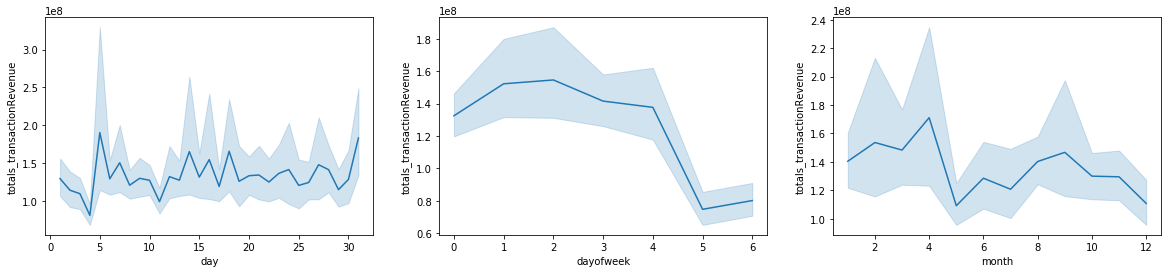

In [13]:
fig, ax =plt.subplots(1,3, figsize=(20,4))
sns.lineplot(x="day", y="totals_transactionRevenue", data=df, ax=ax[0])
sns.lineplot(x="dayofweek", y="totals_transactionRevenue", data=df, ax=ax[1])
sns.lineplot(x="month", y="totals_transactionRevenue", data=df, ax=ax[2])
fig.show()

In [14]:
#subsetting most relevant features as per https://www.kaggle.com/smasar/tutorial-preprocessing-processing-evaluation
column_selection = ["totals_transactionRevenue", "fullVisitorId", "sessionId", "visitId", "visitNumber", "visitStartTime", "month", "dayofweek", "day",
                    "channelGrouping", "device_browser", "device_operatingSystem", "device_deviceCategory", "device_isMobile", "geoNetwork_city",
                    "geoNetwork_continent", "geoNetwork_country","geoNetwork_subContinent", "trafficSource_keyword", "trafficSource_medium", "trafficSource_source"]
df = df[column_selection]
df.head()

,totals_transactionRevenue,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,month,dayofweek,day,channelGrouping,device_browser,device_operatingSystem,device_deviceCategory,device_isMobile,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,trafficSource_keyword,trafficSource_medium,trafficSource_source
0,NaN,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,9,4,2,Organic Search,Chrome,Windows,desktop,False,Izmir,Asia,Turkey,Western Asia,(not provided),organic,google
1,NaN,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,9,4,2,Organic Search,Firefox,Macintosh,desktop,False,not available in demo dataset,Oceania,Australia,Australasia,(not provided),organic,google
2,NaN,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,9,4,2,Organic Search,Chrome,Windows,desktop,False,Madrid,Europe,Spain,Southern Europe,(not provided),organic,google
3,NaN,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,9,4,2,Organic Search,UC Browser,Linux,desktop,False,not available in demo dataset,Asia,Indonesia,Southeast Asia,google + online,organic,google
4,NaN,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,9,4,2,Organic Search,Chrome,Android,mobile,True,not available in demo dataset,Europe,United Kingdom,Northern Europe,(not provided),organic,google


In [16]:
#looking at the information contained in each feature, the closer to 0 the least information
for col in df.columns.tolist():
    p_data = df[col].value_counts()/len(df) #proportion of each feature
    print(col, " entropy: ", sc.stats.entropy(p_data))

totals_transactionRevenue  entropy:  7.621335637674788
fullVisitorId  entropy:  13.297659911529458
sessionId  entropy:  13.712823094035732
visitId  entropy:  13.687267825538878
visitNumber  entropy:  0.9906556013632578
visitStartTime  entropy:  13.688589324938762
month  entropy:  2.4669894122724836
dayofweek  entropy:  1.9334939617842906
day  entropy:  3.4299978095920762
channelGrouping  entropy:  1.460969637162151
device_browser  entropy:  1.0485630851760932
device_operatingSystem  entropy:  1.5229780844083227
device_deviceCategory  entropy:  0.6787941181917714
device_isMobile  entropy:  0.5778321598918738
geoNetwork_city  entropy:  2.5658225052662917
geoNetwork_continent  entropy:  1.171307660409992
geoNetwork_country  entropy:  2.9994415522813322
geoNetwork_subContinent  entropy:  2.077810195955849
trafficSource_keyword  entropy:  0.6302302712270713
trafficSource_medium  entropy:  1.2322834854581473
trafficSource_source  entropy:  1.6726463567884822


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


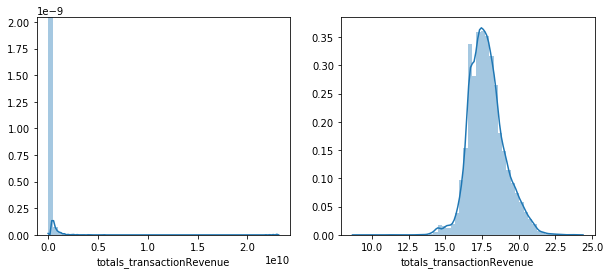

In [17]:
target_var = df["totals_transactionRevenue"][~df["totals_transactionRevenue"].isna()]
fig, ax =plt.subplots(1,2, figsize=(10,4))
sns.distplot(target_var, ax=ax[0])
sns.distplot(np.log(target_var), ax=ax[1])
fig.show()

### Modeling

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [19]:
drop_columns = ["fullVisitorId", "sessionId", "visitId", "visitNumber", "visitStartTime", "totals_transactionRevenue"]
train_y = np.log1p(df["totals_transactionRevenue"].fillna(0.0))
train_X = df.drop(columns=drop_columns)# + ["geoNetwork_country", "geoNetwork_city"])
train_X.head()

,month,dayofweek,day,channelGrouping,device_browser,device_operatingSystem,device_deviceCategory,device_isMobile,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,trafficSource_keyword,trafficSource_medium,trafficSource_source
0,9,4,2,Organic Search,Chrome,Windows,desktop,False,Izmir,Asia,Turkey,Western Asia,(not provided),organic,google
1,9,4,2,Organic Search,Firefox,Macintosh,desktop,False,not available in demo dataset,Oceania,Australia,Australasia,(not provided),organic,google
2,9,4,2,Organic Search,Chrome,Windows,desktop,False,Madrid,Europe,Spain,Southern Europe,(not provided),organic,google
3,9,4,2,Organic Search,UC Browser,Linux,desktop,False,not available in demo dataset,Asia,Indonesia,Southeast Asia,google + online,organic,google
4,9,4,2,Organic Search,Chrome,Android,mobile,True,not available in demo dataset,Europe,United Kingdom,Northern Europe,(not provided),organic,google


In [20]:
#encoding categorical variables
cat_columns = [col for col in train_X.columns if train_X[col].dtype in ["object", "bool"]]

for col in cat_columns:
    le = LabelEncoder()
    train_vals = list(train_X[col].values.astype(str))
    le.fit(train_vals)
    train_X[col] = le.transform(train_vals)    
train_X.head()

,month,dayofweek,day,channelGrouping,device_browser,device_operatingSystem,device_deviceCategory,device_isMobile,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,trafficSource_keyword,trafficSource_medium,trafficSource_source
0,9,4,2,4,11,16,0,0,258,3,204,21,11,5,149
1,9,4,2,4,16,7,0,0,648,5,12,1,11,5,149
2,9,4,2,4,11,16,0,0,325,4,181,19,11,5,149
3,9,4,2,4,46,6,0,0,648,3,94,16,1098,5,149
4,9,4,2,4,11,1,1,1,648,4,211,13,11,5,149


In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [22]:
#https://www.kaggle.com/sishihara/simple-lightgbm-kfold
#https://www.kaggle.com/ogrellier/user-level-lightgbm-lb-1-4480/code

folds = KFold(n_splits=5, shuffle=True, random_state=2018)

oof_preds = np.zeros(train_X.shape[0])
# sub_preds = np.zeros(test_X.shape[0])

lgb_params = {"n_estimators": 500, "learning_rate":0.005, "objective":'regression',"num_leaves":144, "max_depth":13,
          "bagging_fraction" : 0.8, "bagging_freq" : 5, "feature_fraction" : 0.9}
    
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_X)):
    trn_x, trn_y = train_X.iloc[trn_idx], train_y.iloc[trn_idx]
    val_x, val_y = train_X.iloc[val_idx], train_y.iloc[val_idx]
    print(trn_x.shape, trn_y.shape, val_x.shape, val_y.shape)
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(trn_x, trn_y, eval_set= [(trn_x, trn_y), (val_x, val_y)], eval_metric="rmse", early_stopping_rounds=150, verbose=0)
              
    oof_preds[val_idx] = model.predict(val_x, num_iteration=model.best_iteration_)
    print('Fold %2d RSME : %.5f' % (n_fold + 1, rmse(val_y, oof_preds[val_idx])))
print('Full RSME score %.5f' % rmse(train_y, oof_preds))   

(722922, 15) (722922,) (180731, 15) (180731,)
Fold  1 RSME : 1.97204
(722922, 15) (722922,) (180731, 15) (180731,)
Fold  2 RSME : 1.91992
(722922, 15) (722922,) (180731, 15) (180731,)
Fold  3 RSME : 1.94895
(722923, 15) (722923,) (180730, 15) (180730,)
Fold  4 RSME : 1.95783
(722923, 15) (722923,) (180730, 15) (180730,)
Fold  5 RSME : 1.97318
Full RSME score 1.95448


First 50k rows:   
    - Full RSME score 1.98302  
Whole dataset:  
    - Full RSME score 1.95448

## To do
- Aggregate per id
- Test file & Pipeline whole process
- Add more features
- Add more data